In [22]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D

# Repository imports.
import DataGenerator
import LocalNetBase
import network
import train

## Visualize random halfspace data

Note: For the clearest separation, set dim = 2 (we only plot the first two dimensions here).

points: (1000, 3) float64
labels: (1000,) bool


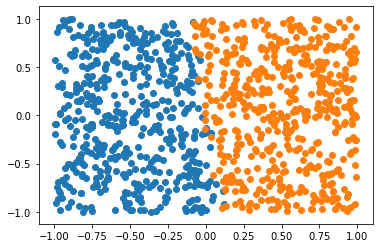

In [23]:
dim = 3
n = 1000
points, labels = DataGenerator.random_halfspace_data(dim, n)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels
zeros = np.invert(labels)
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize random ReLU data

Note: Sometimes, all points end up having the same label.

points: (1000, 2) float32
labels: (1000,) int64


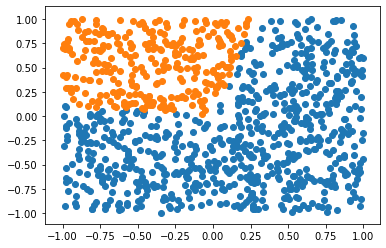

In [24]:
dim = 2
n = 1000
k = 10
points, labels = DataGenerator.layer_relu_data(dim, n, k)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels.astype(np.bool)
zeros = np.invert(ones)
# ax.scatter(points[:, 0][ones], points[:, 1][ones], labels[ones])
# ax.scatter(points[:, 0][zeros], points[:, 1][zeros], labels[zeros])
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize MNIST

In [25]:
import torchvision
import torchvision.datasets
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
print('mnist_train:', len(mnist_train))
print('mnist_test:', len(mnist_test))

mnist_train: 60000
mnist_test: 10000


In [26]:
X = np.array([np.array(pair[0]) for pair in mnist_train]) / 255.0
y = np.array([pair[1] for pair in mnist_train])
X_test = np.array([np.array(pair[0]) for pair in mnist_test]) / 255.0
y_test = np.array([pair[1] for pair in mnist_test])
print('X:', X.shape)
print('y:', y.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
mnist_X, mnist_y, mnist_X_test, mnist_y_test = X, y, X_test, y_test

X: (60000, 28, 28)
y: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


TypeError: Invalid shape (784,) for image data

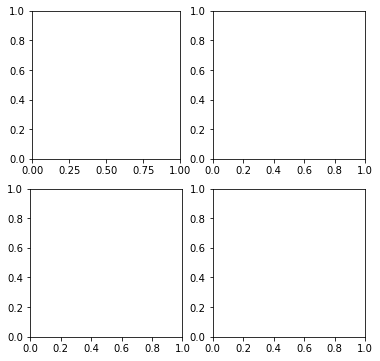

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(X[123])
ax[0, 0].set_title(y[123])
ax[0, 1].imshow(X[456])
ax[0, 1].set_title(y[456])
ax[1, 0].imshow(X_test[123])
ax[1, 0].set_title(y_test[123])
ax[1, 1].imshow(X_test[456])
ax[1, 1].set_title(y_test[456])
plt.show()

## Instantiate and inspect RNN

This is based on the README. Notes:

* The "rounds" parameter seems to be defined as T-1, so rounds=1 <=> T=2!

* The word "graph" in the code refers to the recurrent portion of the RNN, i.e. the randomly, sparsely connected part, excluding input and output neurons.

* I'm not sure as to what the best options are for which scenario, feel free to experiment with this.

In [28]:
options = LocalNetBase.Options(
    use_input_rule = False,    # Use an input rule to update input layer weights.
    use_output_rule = False,   # Use an output rule to update input layer weights.
    gd_output_rule = False,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    use_graph_rule = True,
    gd_graph_rule = True,
    gd_input = False,          # gd directly on input layer weights.
    gd_output = False,         # gd directly on output layer weights.
    additive_rule = True)      # If false, uses multiplicative updates.

scheme = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      # By default, uses cross entropy loss.
    mse_loss = False,
    update_misclassified = True,    # By default only update weights when we misclassify.
    update_all_edges = False)       # For output rule, update all edges, or only edge to correct and predicted label.

local_net = network.LocalNet(n = 4,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
    
print('local_net input_rule:')
print(local_net.input_rule)  # 2^T, randomly initialized
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # 2^T x 2^T, randomly initialized
print('local_net output_rule:')
print(local_net.get_output_rule())  # 2^T x 2, all zero

local_net input_rule:
tensor([ 0.2586, -0.5757, -0.0447, -0.0597])
local_net rnn_rule:
tensor([[-0.0168, -1.0367, -0.1410,  0.7688],
        [-1.1735,  1.9287,  0.1546,  1.5860],
        [-1.2199, -0.6957, -0.1216, -0.2437],
        [ 0.1260, -1.5476, -0.5559,  1.4825]])
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Meta-learn rules using gradient descent on halfspace

In [29]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 2*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Learn rules.
losses, train_accuracies, test_accuracies = train.train_local_rule(
    X,                      # Training Examples
    y,                      # Training Labels
    local_net,              # The BrainNet
    X_test = X_test,
    y_test = y_test,
    rule_epochs = 100,     # Number of times to run through the data
    epochs = 1,             # Number of time to run through a single batch for a single training pass
    batch = 100,            # Number of examples in a batch.
    lr = 1e-2,              # Learning Rate
    verbose = True)         # If True, evaluates network on test/train data each epoch, otherwise, only once at the end

Starting Train
Outer epoch  1
Acc of class 0 :0.8539
Acc of class 1 :0.7432
Train Accuracy: 0.7970
Acc of class 0 :0.8177
Acc of class 1 :0.7098
Test Accuracy: 0.7660
LOSS: 2.571573308178606
Outer epoch  2
Acc of class 0 :0.8333
Acc of class 1 :0.6381
Train Accuracy: 0.7330
Acc of class 0 :0.8733
Acc of class 1 :0.5846
Test Accuracy: 0.7350
LOSS: 2.314923165210918
Outer epoch  3
Acc of class 0 :0.7695
Acc of class 1 :0.5000
Train Accuracy: 0.6310
Acc of class 0 :0.7524
Acc of class 1 :0.5010
Test Accuracy: 0.6320
LOSS: 2.3284974437118318
Outer epoch  4
Acc of class 0 :0.7263
Acc of class 1 :0.5409
Train Accuracy: 0.6310
Acc of class 0 :0.7274
Acc of class 1 :0.5157
Test Accuracy: 0.6260
LOSS: 2.054155161474532
Outer epoch  5
Acc of class 0 :0.5514
Acc of class 1 :0.3891
Train Accuracy: 0.4680
Acc of class 0 :0.5298
Acc of class 1 :0.4008
Test Accuracy: 0.4680
LOSS: 2.0701437956387765
Outer epoch  6
Acc of class 0 :0.8992
Acc of class 1 :0.2004
Train Accuracy: 0.5400
Acc of class 0 :0.8

KeyboardInterrupt: 

In [30]:
# Print rules.
print('local_net input_rule:')
print(local_net.input_rule)  # Same as before (cannot be learned?).
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # Learned.
print('local_net output_rule:')
print(local_net.get_output_rule())  # Same as before (we specified not to learn this).

local_net input_rule:
tensor([ 0.2586, -0.5757, -0.0447, -0.0597])
local_net rnn_rule:
tensor([[ 1.3060e-02, -1.8380e-01,  3.6418e-01,  3.5476e-01],
        [-8.8468e-01,  8.3386e-01, -3.4676e-01,  4.5672e-01],
        [-2.8973e-01, -2.0859e-02,  1.1560e-01, -5.5667e-01],
        [ 1.9764e-03, -2.2305e+00, -4.5221e-01,  5.5573e-01]],
       dtype=torch.float64)
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [31]:
# Plot training curves.
plt.plot(losses, label='losses')
plt.plot(np.reshape(train_accuracies, -1), label='train_acc')
plt.plot(np.reshape(test_accuracies, -1), label='test_acc')
plt.legend()
plt.show()
print('Last outer epoch loss:', losses[-1])
print('Last outer epoch train_accuracies:', train_accuracies[-1])
print('Last outer epoch test_accuracies:', test_accuracies[-1])

NameError: name 'losses' is not defined

## Train with the already learned rules on a different halfspace

In [16]:
# Generate data.
dimension = 4
n = 5000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# NOTE: This method trains only once over all examples, updating the stats every 500 steps.
train_accuracies, test_accuracies = train.train_given_rule(
    X,                      # Training Examples
    y,                      # Training Labels
    local_net,              # The BrainNet
    X_test = X_test,
    y_test = y_test,
    verbose = True)         # If True, evaluates network on test/train data each epoch, otherwise, only once at the end

Train on 0  examples.
Acc of class 0 :1.0000
Acc of class 1 :0.0000
Train Accuracy: 0.4964
Acc of class 0 :1.0000
Acc of class 1 :0.0000
Test Accuracy: 0.4898
Train on 500  examples.
Acc of class 0 :0.0367
Acc of class 1 :0.6050
Train Accuracy: 0.3229
Acc of class 0 :0.0433
Acc of class 1 :0.5919
Test Accuracy: 0.3232
Train on 1000  examples.
Acc of class 0 :0.0485
Acc of class 1 :0.6207
Train Accuracy: 0.3367
Acc of class 0 :0.0519
Acc of class 1 :0.6170
Test Accuracy: 0.3402
Train on 1500  examples.
Acc of class 0 :0.0397
Acc of class 1 :0.6309
Train Accuracy: 0.3374
Acc of class 0 :0.0445
Acc of class 1 :0.6264
Test Accuracy: 0.3414
Train on 2000  examples.
Acc of class 0 :0.0479
Acc of class 1 :0.6398
Train Accuracy: 0.3460
Acc of class 0 :0.0531
Acc of class 1 :0.6374
Test Accuracy: 0.3512
Train on 2500  examples.
Acc of class 0 :0.0373
Acc of class 1 :0.6436
Train Accuracy: 0.3426
Acc of class 0 :0.0416
Acc of class 1 :0.6413
Test Accuracy: 0.3476
Train on 3000  examples.
Acc of 

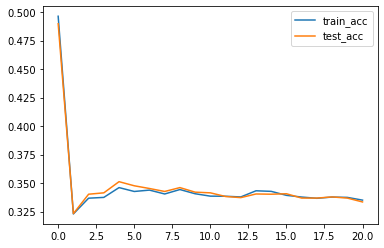

In [17]:
# Plot training curves.
plt.plot(np.reshape(train_accuracies, -1), label='train_acc')
plt.plot(np.reshape(test_accuracies, -1), label='test_acc')
plt.legend()
plt.show()

## Meta-learn rules on halfspace, train with fixed rules on MNIST

NOTE: the reason this doesn't work too well is because the actual procedures in the paper are a little more complicated, see **Appendix A.2**. I suspect the halfspace dimension is much less than 28 x 28 (and the number of classes should obviously be 2, not 10), and then the rules are copied across different networks.

Interestingly, even if the upstream accuracy is chance (50%), the downstream training still works...

In [40]:
# options = LocalNetBase.Options(
#     use_input_rule = False,    # Use an input rule to update input layer weights.
#     use_output_rule = True,   # Use an output rule to update input layer weights.
#     gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
#     use_graph_rule = True,
#     gd_graph_rule = True,
#     gd_input = False,          # gd directly on input layer weights.
#     gd_output = False,         # gd directly on output layer weights.
#     additive_rule = True)      # If false, uses multiplicative updates.

options = LocalNetBase.Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = False, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = True)

scheme = LocalNetBase.UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

# ==== TODO: create different upstream (halfspace) vs downstream (MNIST) network! ====

# Initialize new network.
dimension = 28 * 28
local_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 10,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 0,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)


############################################################
## WARNING!!! THIS prevents training from even happening here.
## if we dont change the options/scheme, adversarial learning doesnt work - Why ??
###############################################################
local_net.input_weights = torch.ones_like(local_net.input_weights).double()
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
# Generate halfspace data.
n = 5000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Learn rules.
losses, train_accuracies, test_accuracies = train.train_local_rule(
    X,                      # Training Examples
    y,                      # Training Labels
    local_net,              # The BrainNet
    X_test = X_test,
    y_test = y_test,
    rule_epochs = 100,     # Number of times to run through the data
    epochs = 1,             # Number of time to run through a single batch for a single training pass
    batch = 100,            # Number of examples in a batch.
    lr = 1e-2,              # Learning Rate
    verbose = True)         # If True, evaluates network on test/train data each epoch, otherwise, only once at the end

ValueError: optimizer got an empty parameter list

In [11]:
# Plot training curves.
plt.plot(losses, label='losses')
plt.plot(np.reshape(train_accuracies, -1), label='train_acc')
plt.plot(np.reshape(test_accuracies, -1), label='test_acc')
plt.legend()
plt.show()
print('Last outer epoch loss:', losses[-1])
print('Last outer epoch train_accuracies:', train_accuracies[-1])
print('Last outer epoch test_accuracies:', test_accuracies[-1])

NameError: name 'losses' is not defined

In [41]:
# Recall MNIST data.
X, y, X_test, y_test = mnist_X, mnist_y, mnist_X_test, mnist_y_test
X = X.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# NOTE: This method trains only once over all examples, updating the stats every 500 steps.
train_accuracies, test_accuracies = train.train_given_rule(
    X,                      # Training Examples
    y,                      # Training Labels
    local_net,              # The BrainNet
    X_test = X_test,
    y_test = y_test,
    verbose = True)         # If True, evaluates network on test/train data each epoch, otherwise, only once at the end

Epoch #: 0
Train on 0  examples.
Acc of class 0 :0.0000
Acc of class 1 :0.0000
Acc of class 2 :0.0000
Acc of class 3 :0.0000
Acc of class 4 :0.0000
Acc of class 5 :0.9956
Acc of class 6 :0.0000
Acc of class 7 :0.0000
Acc of class 8 :0.0000
Acc of class 9 :0.0012
Train Accuracy: 0.0901
Acc of class 0 :0.0000
Acc of class 1 :0.0000
Acc of class 2 :0.0000
Acc of class 3 :0.0000
Acc of class 4 :0.0000
Acc of class 5 :0.9989
Acc of class 6 :0.0000
Acc of class 7 :0.0000
Acc of class 8 :0.0000
Acc of class 9 :0.0000
Test Accuracy: 0.0891
Train on 5000  examples.
Acc of class 0 :0.9105
Acc of class 1 :0.9227
Acc of class 2 :0.6501
Acc of class 3 :0.7152
Acc of class 4 :0.5366
Acc of class 5 :0.4353
Acc of class 6 :0.7423
Acc of class 7 :0.7941
Acc of class 8 :0.3136
Acc of class 9 :0.8158
Train Accuracy: 0.6904
Acc of class 0 :0.9214
Acc of class 1 :0.9348
Acc of class 2 :0.6453
Acc of class 3 :0.7139
Acc of class 4 :0.5316
Acc of class 5 :0.3913
Acc of class 6 :0.7035
Acc of class 7 :0.7763


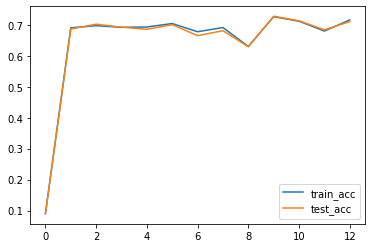

In [42]:
# Plot training curves.
plt.plot(np.reshape(train_accuracies, -1), label='train_acc')
plt.plot(np.reshape(test_accuracies, -1), label='test_acc')
plt.legend()
plt.show()

## Adversaries

Here, we take the test set, and used the Fast Gradient approach outlined in the paper to create perturbed versions of each image in the test set. Specifically, we do the following
1) Take every image, choose a random label which is not the true label and use FGSM to perturb
2) Do this for increasing epsilons

The paper does it differently. They take all 9 alternates and check if prediction fails in any one of the perturbations. It is probably more robust. We do this over the full test set here, whereas the paper chooses just 100 images. Let's figure out later what is appropriate. 

Below we first show how to create adversaries and visualize them. 
Then we run the analysis for the epsilon range. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


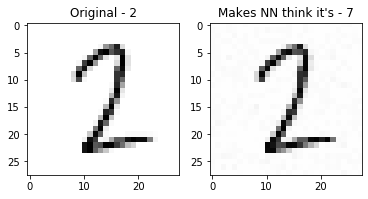

In [188]:
from AdversarialExamples import adversarial_example, random_not_true_label
%load_ext autoreload
%autoreload 2

####################################
# Try different values of example_index and perturb_level to see how the image changes and what it's meant to look like
####################################
example_index = 456
perturb_level = 3

examp_X = torch.from_numpy(X_test[example_index]).double()
examp_Y = y_test[example_index]
not_Y = random_not_true_label(examp_Y)
adv_X = adversarial_example(
    examp_X.reshape(1, -1), torch.tensor([not_Y], dtype=torch.long), 
    local_net.forward_pass, eps=perturb_level, lr=1e-2)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(examp_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
ax[0].set_title( 'Original - '+ str(examp_Y))
ax[1].imshow(adv_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
ax[1].set_title( "Makes NN think it's - " + str(not_Y))
plt.show()

In [183]:
from AdversarialExamples import epsilon_sensitivity_trend
%load_ext autoreload
%autoreload 2

models = {
    'Meta Learned Plasticity' : local_net
}

trend, epsilons = epsilon_sensitivity_trend(models,zip(X_test,y_test),local_net.m)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
7105
**************** EPS:  0.0
ACC:  0.9449683321604504
**************** EPS:  0.5
ACC:  0.8969739619985926
**************** EPS:  1.0
ACC:  0.7007741027445461
**************** EPS:  1.5
ACC:  0.5258268824771288
**************** EPS:  2.0
ACC:  0.36988036593947926
**************** EPS:  2.5
ACC:  0.2685432793807178
**************** EPS:  3.0
ACC:  0.17719915552427867
**************** EPS:  3.5
ACC:  0.12976776917663618


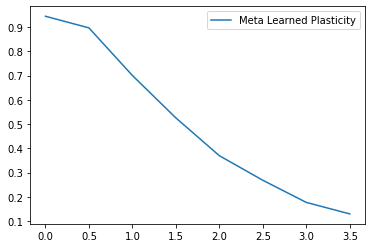

In [185]:
for model_name, series in trend.items():
    plt.plot(epsilons,series, label=model_name)
plt.legend()
plt.show()